# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "QRILC"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'QRILC',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups            
Sample_077  A0A087WUT8;O95196;O95196-2   19.135
Sample_137  Q9UM22                       19.317
Sample_124  Q92743                       15.749
Sample_087  Q24JP5;Q24JP5-2              17.394
Sample_136  A6XMH3;P01236;Q5I0G2         14.916
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by QRILC: runs/alzheimer_study/preds/pred_real_na_QRILC.csv


Sample ID   protein groups          
Sample_007  O75752                     14.964
Sample_051  Q9P1W8;Q9P1W8-2;Q9P1W8-4   14.260
Sample_087  P30048;P30048-2            12.663
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 14.263
            A0A075B6Q5                 12.335
            A0A075B6R2                 12.856
            A0A075B6S5                 12.877
            A0A087WSY4                 13.780
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   11.955
            Q9UI40;Q9UI40-2            11.411
            Q9UIW2                     12.745
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.710
            Q9UP79                     12.600
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,13.221,15.050,16.842,19.863,13.750,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,14.338,19.067,...,15.528,15.576,12.432,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,13.866,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.531,17.705,17.039,14.065,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,11.727,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,12.809,15.345,17.084,18.708,14.249,19.433,9.920,9.674
Sample_207,15.739,16.877,15.469,16.898,12.247,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,14.263,...,16.012,15.178,13.242,15.050,16.842,19.863,13.460,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.028,19.067,16.188,...,15.528,15.576,13.377,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,12.280,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,12.486,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.854,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,11.901,15.345,17.084,18.708,14.249,19.433,12.343,11.637
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 402.37it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.28it/s]

100%|██████████| 2/2 [00:00<00:00,  6.26it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.16it/s]

100%|██████████| 3/3 [00:00<00:00,  4.21it/s]

100%|██████████| 3/3 [00:00<00:00,  4.49it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.57it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.38it/s]

100%|██████████| 4/4 [00:00<00:00,  3.93it/s]

100%|██████████| 4/4 [00:00<00:00,  4.26it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.15it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.32it/s]

 80%|████████  | 4/5 [00:00<00:00,  3.70it/s]

100%|██████████| 5/5 [00:01<00:00,  3.65it/s]

100%|██████████| 5/5 [00:01<00:00,  3.93it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.94it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.30it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  3.73it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.42it/s]

100%|██████████| 6/6 [00:01<00:00,  3.23it/s]

100%|██████████| 6/6 [00:01<00:00,  3.62it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.76it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.58it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.00it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.54it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.39it/s]

100%|██████████| 7/7 [00:01<00:00,  3.40it/s]

100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.10it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.50it/s]

 50%|█████     | 4/8 [00:00<00:01,  3.90it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.62it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.37it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.47it/s]

100%|██████████| 8/8 [00:02<00:00,  3.30it/s]

100%|██████████| 8/8 [00:02<00:00,  3.63it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.86it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.89it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.23it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.79it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.53it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.59it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.59it/s]

100%|██████████| 9/9 [00:02<00:00,  3.59it/s]

100%|██████████| 9/9 [00:02<00:00,  3.86it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.66it/s]

 30%|███       | 3/10 [00:00<00:01,  3.76it/s]

 40%|████      | 4/10 [00:01<00:02,  2.80it/s]

 50%|█████     | 5/10 [00:01<00:02,  2.44it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.24it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.24it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.27it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.16it/s]

100%|██████████| 10/10 [00:04<00:00,  2.11it/s]

100%|██████████| 10/10 [00:04<00:00,  2.40it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  4.83it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.65it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.59it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.42it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.37it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.39it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.27it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.17it/s]

 91%|█████████ | 10/11 [00:04<00:00,  2.21it/s]

100%|██████████| 11/11 [00:04<00:00,  2.20it/s]

100%|██████████| 11/11 [00:04<00:00,  2.40it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.66it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.70it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.20it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.30it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.21it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  3.11it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.65it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.42it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.25it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.27it/s]

100%|██████████| 12/12 [00:04<00:00,  2.40it/s]

100%|██████████| 12/12 [00:04<00:00,  2.73it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.21it/s]

 23%|██▎       | 3/13 [00:00<00:03,  2.91it/s]

 31%|███       | 4/13 [00:01<00:03,  2.77it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.34it/s]

 46%|████▌     | 6/13 [00:02<00:03,  2.09it/s]

 54%|█████▍    | 7/13 [00:03<00:03,  1.93it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.08it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.29it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.40it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.45it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.64it/s]

100%|██████████| 13/13 [00:05<00:00,  2.80it/s]

100%|██████████| 13/13 [00:05<00:00,  2.50it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.74it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.00it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.60it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.40it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.21it/s]

 50%|█████     | 7/14 [00:02<00:02,  3.31it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.33it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.34it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.31it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.31it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  2.84it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.35it/s]

100%|██████████| 14/14 [00:04<00:00,  2.05it/s]

100%|██████████| 14/14 [00:04<00:00,  2.85it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  6.69it/s]

 20%|██        | 3/15 [00:00<00:02,  4.64it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.14it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.13it/s]

 40%|████      | 6/15 [00:01<00:03,  2.38it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.04it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  1.90it/s]

 60%|██████    | 9/15 [00:03<00:03,  1.91it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  2.02it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.17it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.21it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.26it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.28it/s]

100%|██████████| 15/15 [00:06<00:00,  2.30it/s]

100%|██████████| 15/15 [00:06<00:00,  2.39it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.001      0.042 0.006          0.805 0.314       0.135   
2             0.003 0.000      0.044 0.003          0.668 0.120       0.595   
3             0.004 0.001      0.047 0.003          0.762 0.081       0.745   
4             0.004 0.000      0.046 0.000          0.772 0.083       0.734   
5             0.004 0.000      0.046 0.000          0.773 0.089       0.724   
6             0.004 0.001      0.047 0.001          0.778 0.102       0.743   
7             0.004 0.000      0.047 0.001          0.808 0.085       0.844   
8             0.004 0.001      0.047 0.002          0.810 0.088       0.843   
9             0.004 0.001      0.043 0.003          0.802 0.091       0.834   
10            0.004 0.001      0.045 0.010          0.809 0.089       0.825   
11            0.005 0.004      0.062 0.023          0.816 0.082       0.837   
12            0.006 0.005      0.063 0.023          0.812 0.078       0.831   
13            0.004 0.002      0.067 0.030          0.829 0.075       0.835   
14            0.006 0.005      0.066 0.026          0.818 0.080       0.836   
15            0.004 0.002      0.048 0.004          0.816 0.079       0.838   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.088   0.223 0.132                  0.560 0.043        0.862   
2          0.123   0.621 0.100                  0.685 0.077        0.781   
3          0.095   0.750 0.071                  0.786 0.058        0.853   
4          0.099   0.748 0.070                  0.786 0.057        0.855   
5          0.102   0.742 0.073                  0.782 0.058        0.858   
6          0.098   0.755 0.075                  0.790 0.062        0.857   
7          0.094   0.821 0.064                  0.847 0.055        0.901   
8          0.089   0.821 0.063                  0.846 0.054        0.899   
9          0.102   0.813 0.072                  0.840 0.062        0.898   
10         0.106   0.812 0.073                  0.839 0.062        0.901   
11         0.094   0.823 0.070                  0.848 0.060        0.915   
12         0.086   0.818 0.064                  0.844 0.055        0.913   
13         0.086   0.830 0.068                  0.855 0.059        0.916   
14         0.094   0.823 0.068                  0.849 0.060        0.916   
15         0.094   0.824 0.070                  0.849 0.062        0.915   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.828 0.088        210.000 0.000  
2          0.078                  0.696 0.101        210.000 0.000  
3          0.060                  0.805 0.086        210.000 0.000  
4          0.061                  0.811 0.091        210.000 0.000  
5          0.060                  0.813 0.089        210.000 0.000  
6          0.056                  0.817 0.083        210.000 0.000  
7          0.049                  0.876 0.061        210.000 0.000  
8          0.049                  0.875 0.062        210.000 0.000  
9          0.050                  0.874 0.063        210.000 0.000  
10         0.050                  0.878 0.064        210.000 0.000  
11         0.049                  0.902 0.058        210.000 0.000  
12         0.050                  0.898 0.059        210.000 0.000  
13         0.048                  0.899 0.056        210.000 0.000  
14         0.049                  0.903 0.054        210.000 0.000  
15         0.050                  0.901 0.055 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 475.06it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.04it/s]

100%|██████████| 2/2 [00:00<00:00,  5.01it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.53it/s]

100%|██████████| 3/3 [00:00<00:00,  4.20it/s]

100%|██████████| 3/3 [00:00<00:00,  4.39it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.43it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.02it/s]

100%|██████████| 4/4 [00:01<00:00,  2.82it/s]

100%|██████████| 4/4 [00:01<00:00,  3.01it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.28it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.00it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.56it/s]

100%|██████████| 5/5 [00:01<00:00,  2.59it/s]

100%|██████████| 5/5 [00:01<00:00,  2.77it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.62it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.53it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.03it/s]

 83%|████████▎ | 5/6 [00:02<00:00,  1.79it/s]

100%|██████████| 6/6 [00:02<00:00,  1.78it/s]

100%|██████████| 6/6 [00:02<00:00,  2.04it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.87it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.23it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.53it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.31it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.27it/s]

100%|██████████| 7/7 [00:02<00:00,  3.17it/s]

100%|██████████| 7/7 [00:02<00:00,  3.46it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  3.93it/s]

 38%|███▊      | 3/8 [00:01<00:01,  2.73it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.65it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.67it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.71it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.75it/s]

100%|██████████| 8/8 [00:02<00:00,  2.82it/s]

100%|██████████| 8/8 [00:02<00:00,  2.81it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.27it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.10it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.62it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.56it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.44it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.41it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.49it/s]

100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

100%|██████████| 9/9 [00:03<00:00,  2.64it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.03it/s]

 30%|███       | 3/10 [00:00<00:01,  3.51it/s]

 40%|████      | 4/10 [00:01<00:01,  3.07it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.83it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.70it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.61it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.64it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.27it/s]

100%|██████████| 10/10 [00:04<00:00,  1.99it/s]

100%|██████████| 10/10 [00:04<00:00,  2.49it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  3.53it/s]

 27%|██▋       | 3/11 [00:01<00:03,  2.53it/s]

 36%|███▋      | 4/11 [00:01<00:03,  2.25it/s]

 45%|████▌     | 5/11 [00:02<00:02,  2.41it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.43it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.55it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.64it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.62it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.63it/s]

100%|██████████| 11/11 [00:04<00:00,  2.36it/s]

100%|██████████| 11/11 [00:04<00:00,  2.50it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.08it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.05it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.60it/s]

 42%|████▏     | 5/12 [00:01<00:03,  2.27it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.06it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.13it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.21it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.36it/s]

 83%|████████▎ | 10/12 [00:04<00:00,  2.23it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.22it/s]

100%|██████████| 12/12 [00:05<00:00,  2.09it/s]

100%|██████████| 12/12 [00:05<00:00,  2.30it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.31it/s]

 23%|██▎       | 3/13 [00:00<00:03,  3.00it/s]

 31%|███       | 4/13 [00:01<00:04,  2.23it/s]

 38%|███▊      | 5/13 [00:02<00:03,  2.06it/s]

 46%|████▌     | 6/13 [00:02<00:03,  2.21it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.33it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.37it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.33it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.02it/s]

 85%|████████▍ | 11/13 [00:04<00:01,  1.87it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  1.85it/s]

100%|██████████| 13/13 [00:06<00:00,  1.85it/s]

100%|██████████| 13/13 [00:06<00:00,  2.13it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.62it/s]

 21%|██▏       | 3/14 [00:01<00:04,  2.69it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.12it/s]

 36%|███▌      | 5/14 [00:02<00:04,  1.83it/s]

 43%|████▎     | 6/14 [00:02<00:04,  1.95it/s]

 50%|█████     | 7/14 [00:03<00:03,  2.10it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.10it/s]

 64%|██████▍   | 9/14 [00:04<00:02,  2.28it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.34it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.36it/s]

 86%|████████▌ | 12/14 [00:05<00:00,  2.41it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.55it/s]

100%|██████████| 14/14 [00:05<00:00,  2.63it/s]

100%|██████████| 14/14 [00:05<00:00,  2.36it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.00it/s]

 20%|██        | 3/15 [00:00<00:03,  3.61it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.09it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.12it/s]

 40%|████      | 6/15 [00:01<00:03,  2.94it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.89it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.91it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.77it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  2.38it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.16it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.00it/s]

 87%|████████▋ | 13/15 [00:05<00:01,  1.81it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  1.89it/s]

100%|██████████| 15/15 [00:06<00:00,  1.91it/s]

100%|██████████| 15/15 [00:06<00:00,  2.37it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.058 0.020          0.825 0.274       0.140   
2             0.006 0.004      0.083 0.037          0.606 0.108       0.479   
3             0.005 0.004      0.075 0.036          0.818 0.083       0.727   
4             0.004 0.000      0.047 0.005          0.807 0.084       0.763   
5             0.005 0.004      0.061 0.026          0.812 0.084       0.755   
6             0.005 0.003      0.062 0.020          0.809 0.086       0.752   
7             0.007 0.007      0.080 0.031          0.838 0.089       0.793   
8             0.006 0.005      0.073 0.034          0.843 0.087       0.796   
9             0.005 0.004      0.060 0.026          0.826 0.088       0.836   
10            0.005 0.003      0.057 0.020          0.824 0.081       0.831   
11            0.006 0.004      0.066 0.019          0.831 0.076       0.823   
12            0.006 0.005      0.070 0.023          0.849 0.085       0.834   
13            0.004 0.001      0.047 0.010          0.848 0.081       0.836   
14            0.007 0.006      0.078 0.030          0.851 0.088       0.823   
15            0.006 0.006      0.068 0.027          0.846 0.084       0.817   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.084   0.232 0.124                  0.562 0.042        0.853   
2          0.124   0.526 0.098                  0.624 0.064        0.706   
3          0.103   0.765 0.072                  0.803 0.058        0.910   
4          0.113   0.779 0.075                  0.813 0.061        0.911   
5          0.105   0.777 0.074                  0.812 0.060        0.908   
6          0.103   0.775 0.073                  0.809 0.059        0.906   
7          0.101   0.810 0.074                  0.839 0.063        0.917   
8          0.109   0.813 0.073                  0.841 0.061        0.917   
9          0.099   0.827 0.074                  0.852 0.064        0.924   
10         0.106   0.824 0.074                  0.850 0.063        0.923   
11         0.109   0.823 0.076                  0.850 0.065        0.926   
12         0.093   0.838 0.068                  0.861 0.058        0.928   
13         0.094   0.838 0.067                  0.861 0.057        0.927   
14         0.092   0.833 0.072                  0.857 0.060        0.928   
15         0.094   0.828 0.069                  0.853 0.058        0.925   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.825 0.088        210.000 0.000  
2          0.079                  0.656 0.097        210.000 0.000  
3          0.043                  0.884 0.058        210.000 0.000  
4          0.044                  0.885 0.056        210.000 0.000  
5          0.045                  0.885 0.056        210.000 0.000  
6          0.047                  0.883 0.056        210.000 0.000  
7          0.048                  0.897 0.060        210.000 0.000  
8          0.049                  0.898 0.060        210.000 0.000  
9          0.046                  0.909 0.053        210.000 0.000  
10         0.046                  0.909 0.050        210.000 0.000  
11         0.046                  0.913 0.051        210.000 0.000  
12         0.046                  0.916 0.051        210.000 0.000  
13         0.045                  0.915 0.051        210.000 0.000  
14         0.044                  0.914 0.051        210.000 0.000  
15         0.045                  0.912 0.051 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 985.27it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 20.81it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 19.58it/s]

100%|██████████| 3/3 [00:00<00:00, 19.23it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 19.36it/s]

100%|██████████| 4/4 [00:00<00:00, 10.93it/s]

100%|██████████| 4/4 [00:00<00:00, 11.20it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 26.23it/s]

100%|██████████| 5/5 [00:00<00:00, 18.45it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00, 18.08it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  9.83it/s]

100%|██████████| 6/6 [00:00<00:00,  8.81it/s]

100%|██████████| 6/6 [00:00<00:00,  9.45it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 15.55it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 11.58it/s]

100%|██████████| 7/7 [00:00<00:00, 11.83it/s]

100%|██████████| 7/7 [00:00<00:00, 11.87it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00, 13.73it/s]

 50%|█████     | 4/8 [00:00<00:00,  9.05it/s]

 62%|██████▎   | 5/8 [00:00<00:00,  8.17it/s]

 75%|███████▌  | 6/8 [00:00<00:00,  8.38it/s]

100%|██████████| 8/8 [00:00<00:00,  8.33it/s]

100%|██████████| 8/8 [00:00<00:00,  8.64it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 17.44it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 13.43it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 11.62it/s]

100%|██████████| 9/9 [00:00<00:00, 11.72it/s]

100%|██████████| 9/9 [00:00<00:00, 12.30it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 12.91it/s]

 50%|█████     | 5/10 [00:00<00:00, 10.67it/s]

 70%|███████   | 7/10 [00:00<00:00, 10.12it/s]

 90%|█████████ | 9/10 [00:00<00:00, 10.03it/s]

100%|██████████| 10/10 [00:00<00:00, 10.26it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 14.34it/s]

 45%|████▌     | 5/11 [00:00<00:00, 12.65it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 10.48it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 10.90it/s]

100%|██████████| 11/11 [00:00<00:00, 11.36it/s]

100%|██████████| 11/11 [00:00<00:00, 11.45it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 21.48it/s]

 50%|█████     | 6/12 [00:00<00:00, 15.76it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 14.88it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 14.08it/s]

100%|██████████| 12/12 [00:00<00:00, 11.43it/s]

100%|██████████| 12/12 [00:00<00:00, 13.08it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 18.49it/s]

 38%|███▊      | 5/13 [00:00<00:00, 11.57it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 11.81it/s]

 69%|██████▉   | 9/13 [00:00<00:00,  9.88it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 11.29it/s]

100%|██████████| 13/13 [00:01<00:00, 10.48it/s]

100%|██████████| 13/13 [00:01<00:00, 11.02it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 19.30it/s]

 36%|███▌      | 5/14 [00:00<00:00, 16.10it/s]

 50%|█████     | 7/14 [00:00<00:00, 14.99it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 13.81it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 13.10it/s]

 93%|█████████▎| 13/14 [00:00<00:00, 13.16it/s]

100%|██████████| 14/14 [00:01<00:00, 13.86it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 17.77it/s]

 33%|███▎      | 5/15 [00:00<00:00, 13.74it/s]

 47%|████▋     | 7/15 [00:00<00:00, 11.75it/s]

 60%|██████    | 9/15 [00:00<00:00, 11.53it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 11.51it/s]

 87%|████████▋ | 13/15 [00:01<00:00, 10.71it/s]

100%|██████████| 15/15 [00:01<00:00, 11.39it/s]

100%|██████████| 15/15 [00:01<00:00, 11.63it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.072 0.034          0.140 0.336       0.013   
2             0.006 0.005      0.067 0.029          0.179 0.357       0.020   
3             0.005 0.004      0.063 0.029          0.561 0.245       0.181   
4             0.006 0.008      0.069 0.027          0.564 0.200       0.231   
5             0.005 0.004      0.056 0.020          0.541 0.184       0.256   
6             0.006 0.006      0.072 0.034          0.531 0.155       0.279   
7             0.004 0.000      0.051 0.017          0.490 0.129       0.283   
8             0.006 0.005      0.079 0.039          0.485 0.118       0.284   
9             0.004 0.002      0.049 0.012          0.472 0.130       0.273   
10            0.007 0.006      0.083 0.031          0.516 0.147       0.318   
11            0.004 0.002      0.057 0.021          0.487 0.130       0.314   
12            0.007 0.006      0.088 0.034          0.492 0.119       0.354   
13            0.004 0.001      0.056 0.016          0.481 0.101       0.374   
14            0.007 0.005      0.072 0.028          0.488 0.101       0.397   
15            0.005 0.002      0.054 0.017          0.513 0.097       0.417   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.032   0.023 0.056                  0.499 0.020        0.711   
2          0.040   0.034 0.066                  0.499 0.022        0.673   
3          0.090   0.259 0.110                  0.530 0.050        0.617   
4          0.089   0.315 0.105                  0.542 0.054        0.609   
5          0.100   0.334 0.101                  0.538 0.062        0.596   
6          0.098   0.355 0.099                  0.542 0.063        0.588   
7          0.090   0.350 0.087                  0.528 0.057        0.573   
8          0.091   0.350 0.087                  0.528 0.054        0.561   
9          0.091   0.338 0.087                  0.520 0.056        0.543   
10         0.098   0.384 0.101                  0.543 0.069        0.546   
11         0.105   0.374 0.101                  0.533 0.067        0.535   
12         0.101   0.405 0.097                  0.540 0.068        0.547   
13         0.094   0.416 0.089                  0.539 0.064        0.557   
14         0.106   0.434 0.096                  0.547 0.070        0.572   
15         0.101   0.454 0.083                  0.561 0.065        0.577   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.076                  0.649 0.096        210.000 0.000  
2          0.090                  0.605 0.104        210.000 0.000  
3          0.093                  0.555 0.095        210.000 0.000  
4          0.094                  0.555 0.094        210.000 0.000  
5          0.096                  0.546 0.096        210.000 0.000  
6          0.098                  0.543 0.096        210.000 0.000  
7          0.091                  0.528 0.085        210.000 0.000  
8          0.090                  0.523 0.083        210.000 0.000  
9          0.097                  0.513 0.088        210.000 0.000  
10         0.098                  0.535 0.089        210.000 0.000  
11         0.097                  0.528 0.089        210.000 0.000  
12         0.092                  0.528 0.085        210.000 0.000  
13         0.081                  0.544 0.082        210.000 0.000  
14         0.080                  0.554 0.079        210.000 0.000  
15         0.071                  0.564 0.071 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,12,7,14
score_time,13,2,12
test_precision,13,14,4
test_recall,7,13,15
test_f1,13,13,15
test_balanced_accuracy,13,13,15
test_roc_auc,14,14,1
test_average_precision,14,12,1
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.41it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.92it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.29it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.18it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.03it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.76it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.82it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  2.86it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.82it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.59it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.74it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.72it/s]

100%|██████████| 14/14 [00:04<00:00,  2.78it/s]

100%|██████████| 14/14 [00:04<00:00,  2.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 996.51it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.51it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.90it/s]

 29%|██▊       | 4/14 [00:00<00:02,  3.96it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.95it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.63it/s]

 50%|█████     | 7/14 [00:01<00:02,  3.46it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.40it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.28it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.08it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.05it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.11it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.07it/s]

100%|██████████| 14/14 [00:04<00:00,  2.79it/s]

100%|██████████| 14/14 [00:04<00:00,  3.25it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf


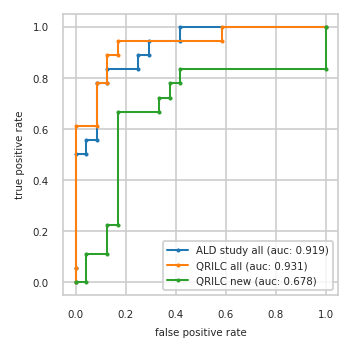

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       QRILC all       QRILC new      
             fpr   tpr       fpr   tpr       fpr   tpr
0          0.000 0.000     0.000 0.000     0.000 0.000
1          0.000 0.056     0.000 0.056     0.042 0.000
2          0.000 0.500     0.000 0.611     0.042 0.111
3          0.042 0.500     0.083 0.611     0.125 0.111
4          0.042 0.556     0.083 0.778     0.125 0.222
5          0.083 0.556     0.125 0.778     0.167 0.222
6          0.083 0.778     0.125 0.889     0.167 0.667
7          0.125 0.778     0.167 0.889     0.333 0.667
8          0.125 0.833     0.167 0.944     0.333 0.722
9          0.250 0.833     0.583 0.944     0.375 0.722
10         0.250 0.889     0.583 1.000     0.375 0.778
11         0.292 0.889     1.000 1.000     0.417 0.778
12         0.292 0.944       NaN   NaN     0.417 0.833
13         0.417 0.944       NaN   NaN     1.000 0.833
14         0.417 1.000       NaN   NaN     1.000 1.000
15         1.000 1.000       NaN   NaN       NaN   NaN

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,QRILC all,QRILC new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,A6PVN5;F6WIT2;Q15257;Q15257-2;Q15257-3
1,I3L3R5,A0A0J9YX35,None
2,Q15782;Q15782-6,P15151-2,None
3,P04075,P61981,None
4,P61981,Q9Y2T3;Q9Y2T3-3,None
5,P14174,P14174,None
6,Q9Y2T3;Q9Y2T3-3,P04075,None
7,Q6EMK4,P05413;S4R371,None
8,P00338;P00338-3,P08294,None


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf


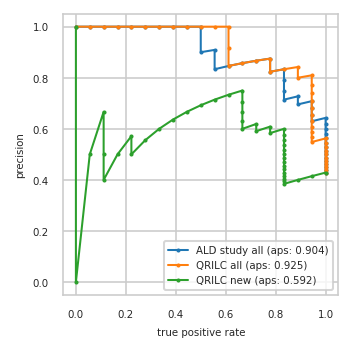

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all       QRILC all       QRILC new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.415 0.944
2          0.450 1.000     0.450 1.000     0.400 0.889
3          0.462 1.000     0.462 1.000     0.385 0.833
4          0.474 1.000     0.474 1.000     0.395 0.833
5          0.486 1.000     0.486 1.000     0.405 0.833
6          0.500 1.000     0.500 1.000     0.417 0.833
7          0.514 1.000     0.514 1.000     0.429 0.833
8          0.529 1.000     0.529 1.000     0.441 0.833
9          0.545 1.000     0.545 1.000     0.455 0.833
10         0.562 1.000     0.562 1.000     0.469 0.833
11         0.581 1.000     0.548 0.944     0.484 0.833
12         0.600 1.000     0.567 0.944     0.500 0.833
13         0.621 1.000     0.586 0.944     0.517 0.833
14         0.643 1.000     0.607 0.944     0.536 0.833
15         0.630 0.944     0.630 0.944     0.556 0.833
16         0.654 0.944     0.654 0.944     0.577 0.833
17         0.680 0.944     0.680 0.944     0.600 0.833
18         0.708 0.944     0.708 0.944     0.583 0.778
19         0.696 0.889     0.739 0.944     0.609 0.778
20         0.727 0.889     0.773 0.944     0.591 0.722
21         0.714 0.833     0.810 0.944     0.619 0.722
22         0.750 0.833     0.800 0.889     0.600 0.667
23         0.789 0.833     0.842 0.889     0.632 0.667
24         0.833 0.833     0.833 0.833     0.667 0.667
25         0.824 0.778     0.824 0.778     0.706 0.667
26         0.875 0.778     0.875 0.778     0.750 0.667
27         0.867 0.722     0.867 0.722     0.733 0.611
28         0.857 0.667     0.857 0.667     0.714 0.556
29         0.846 0.611     0.846 0.611     0.692 0.500
30         0.833 0.556     0.917 0.611     0.667 0.444
31         0.909 0.556     1.000 0.611     0.636 0.389
32         0.900 0.500     1.000 0.556     0.600 0.333
33         1.000 0.500     1.000 0.500     0.556 0.278
34         1.000 0.444     1.000 0.444     0.500 0.222
35         1.000 0.389     1.000 0.389     0.571 0.222
36         1.000 0.333     1.000 0.333     0.500 0.167
37         1.000 0.278     1.000 0.278     0.400 0.111
38         1.000 0.222     1.000 0.222     0.500 0.111
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf


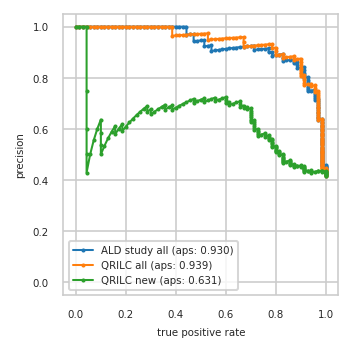

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf


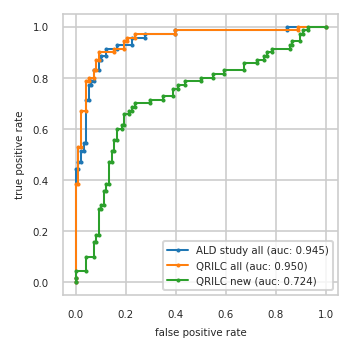

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_QRILC all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC all.pkl'),
 'results_QRILC new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf')}